# Tutorial 1: Principle of Satellite Remote Sensing

**Content creators:** Daniele Corradini

**Content reviewers:** Claudia Acquistapace, Paula Bigalke

**Affiliation:** Institute of Geophysics and Meteorology, University of Cologne, Germany

# Tutorial Objectives

In this tutorial, students should get familiar in effectively managing geostationary satellite data from MSG using Python, learning how to visualize it and utilize its channels to extract meaningful cloud properties.

By the end of this tutorial you will be able to:

* Plot Visible (VIS) and Infrared (IR) channels after filtering outliers and selecting case studies
* Understand how to use MSG channels and their combinations to understand cloud and enviromental features.

# Setup

Understand how the students should run this tutorial and how they will access the data

For now just pretend they can access the institute cluster

Here, I am usinf Python 3.10.12 Kernel (installed with Jupyter PowerToys extenion in VC code). Maybe also give more instruction on how to run it. It can be run easilty also without VC code? Maybe important to define an enviroment with all the needed packages?

Create a google colab notebook and update data in google drive.

## Import libraries

In [2]:
# imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#needs to be installed after creating the env: satpy, matploylib, cartopy

## Section 1: Data Preprocessing

This section focuses on accessing and processing MSG satellite data stored in netCDF format. We will explore a case study involving a hailstorm that occurred in Northern Italy on July 24, 2023. Key steps in our data preprocessing will include:

    - Opening the Data: Using xarray to load the dataset, which allows for efficient handling and manipulation of the data.
    - Spatial Visualization: Plotting spatial maps for selected timestamps to visually assess the data at different intervals.
    - Domain Cropping: Narrowing down the dataset to the area of interest, focusing on the region most affected by the hailstorm.
    - Nighttime Data Filtering: Excluding or flagging data collected during nighttime to ensure the analysis is confined to daytime observations when satellite imagery is most effective.
    - Outlier Detection: Examining the distribution of the data to identify and address any outliers that may skew the analysis.
    - Understanding Parallax Correction: Discussing the significance of parallax correction in satellite data to enhance the accuracy of geolocation.
    - Data Regridding: Explaining the process and importance of regridding the data for consistency in spatial analysis across different datasets.

These preprocessing steps are crucial for setting up a robust analysis framework, ensuring that subsequent analyses are based on accurate and relevant satellite data.

1.1 Open Dataset

Define the time span, and open Dataset using xarray

In [3]:
# Define path and filepattern
filepattern = "MSG*.nc"
folder_path = "/data/sat/msg/netcdf/noparallax/2023/07/24/" #When available use the parallaxed corrected here

# Get the list of all file paths
fnames = sorted(glob(folder_path+filepattern))
len(f'Number of timestamps: {len(fnames)}')

# Open the datasets using xarray, merging along the time dimension
ds = xr.open_mfdataset(fnames, combine='nested', concat_dim='time', parallel=True)

ds


<xarray.Dataset> Size: 354MB
Dimensions:  (time: 96, y: 239, x: 351)
Coordinates:
    lat      (y) float32 956B dask.array<chunksize=(239,), meta=np.ndarray>
    lon      (x) float32 1kB dask.array<chunksize=(351,), meta=np.ndarray>
  * time     (time) datetime64[ns] 768B 2023-07-24 ... 2023-07-24T23:04:05
Dimensions without coordinates: y, x
Data variables:
    IR_016   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    IR_039   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    IR_087   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    IR_097   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    IR_108   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    IR_120   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    IR_134   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    VIS006   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    VIS008   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    WV_062   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    WV_073   (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>

## Plot Maps

Plot channels map for a timestamp



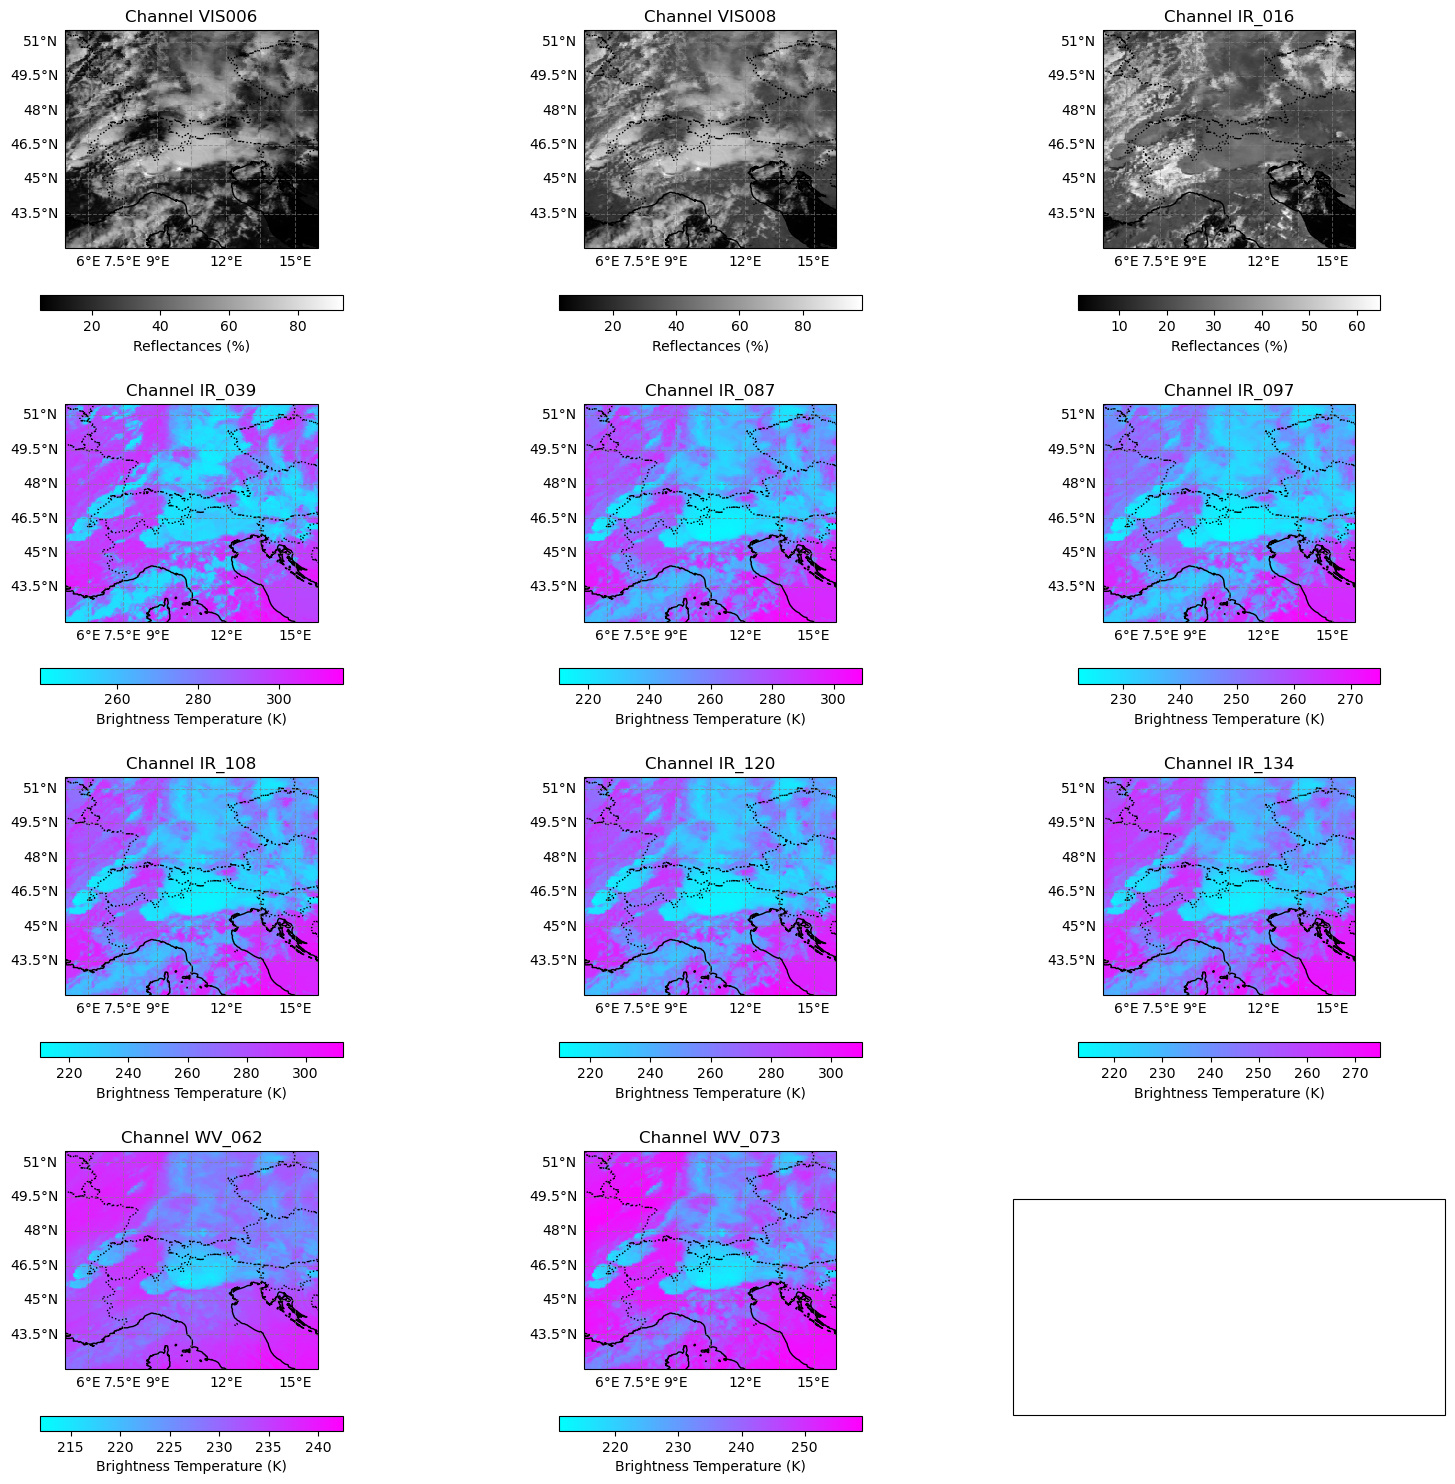

In [4]:
channels = ['VIS006', 'VIS008','IR_016', 'IR_039', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134', 'WV_062', 'WV_073']
channels_unit = ['Reflectances (%)','Reflectances (%)','Reflectances (%)', 'Brightness Temperature (K)', 'Brightness Temperature (K)', 'Brightness Temperature (K)', 'Brightness Temperature (K)', 'Brightness Temperature (K)','Brightness Temperature (K)','Brightness Temperature (K)','Brightness Temperature (K)']
channels_cmaps = ['gray','gray', 'gray', 'cool', 'cool', 'cool', 'cool', 'cool', 'cool', 'cool', 'cool'] 

extent = lon_min, lon_max, lat_min, lat_max = 5., 16., 42., 51.5

# Select a timestamp
data_ss = ds.isel(time=50)

def plot_single_map(ds, extent, channel, ax, channel_unit, channel_cmap):

    ch_data = ds[channel]

    # Effettuare il plot dei dati del canale corrente
    ch_plot = ax.pcolormesh(ch_data['lon'], ch_data['lat'], ch_data.values.squeeze(),
                                transform=ccrs.PlateCarree(), cmap=channel_cmap, shading='nearest')

    # Aggiungere le linee costiere e i confini dei paesi
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Aggiungere una barra dei colori
    cbar = plt.colorbar(ch_plot, ax=ax, orientation='horizontal', shrink=0.7)
    cbar.set_label(channel_unit)

    # Impostare i limiti di estensione della mappa automaticamente in base ai dati
    ax.set_extent(extent)


    #set axis thick labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.75, color='gray', alpha=0.6, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    # Aggiungere il titolo del subplot
    ax.set_title(f'Channel {channel}')

    return ch_plot


def plot_channels(channels, extent, data_ss, channels_cmaps, channels_unit):
    num_rows = 4
    num_cols = 3
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.flatten()

    # Plot each channel
    for i, channel in enumerate(channels):
        plot_single_map(data_ss, extent, channel,axs[i],channels_unit[i],channels_cmaps[i])

    # Adjust layout
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    # Show plot
    plt.show()

plot_channels(channels, extent, data_ss, channels_cmaps, channels_unit)

Now try to run again the code but setting the time in line 12 at 5. What happen to the VIS and NIR channels?
Can you guess why?

Remove the nighttime in the dataset for the VIS/NIR channels 

In [5]:
#mask the nighttime for VIS/NIR channels

#Choose time thresholds far from the sunsets and sunrise, considering also the period of the year (Summer!)
#Be careful that the time of the dataset is given in UTC!
time_min = 8
time_max = 16

time_mask = (ds['time.hour'] >= time_min) & (ds['time.hour'] <= time_max)

# Apply the mask across selected variables 
selected_vars = ['IR_016', 'VIS006', 'VIS008']
for var in selected_vars:
    ds[var] = ds[var].where(time_mask, np.nan)

## Plotting the time trend

Plot the time trend to check if the nighttime mask worked

In [ ]:
# Compute 25-50-75th percentile and plot them along the time

ds_quantile = ds.quantile([0.25, 0.5, 0.75], dim=['x', 'y'])
#print(ds_quantile)


# Loop through each variable in the dataset
for i, var in enumerate(ds_quantile.data_vars):
    ds_quantile[var].plot.line(x='time', hue='quantile', add_legend=True)
    plt.title(f'Time Trend of Percentiles for {var}')
    plt.xlabel('Time')
    plt.ylabel(channels_unit[i])
    plt.grid(True)
    plt.show()

## Cropping Data

Now, crop the data on a specific domain of interest and plot the map of each channel.

In [ ]:
# Coordinates for Trento area
lon_min, lon_max, lat_min, lat_max = 10, 12, 45, 47

# Assuming 'ds' is your xarray Dataset and has coordinates named 'lat' and 'lon'
ds_Trento = ds.copy(deep=True)  # Making a deep copy of the dataset

# Compute the conditions
condition = ((ds_Trento.lon >= lon_min) & (ds_Trento.lon <= lon_max) &
             (ds_Trento.lat >= lat_min) & (ds_Trento.lat <= lat_max)).compute()

# Crop the dataset around the specified coordinates
ds_Trento = ds_Trento.where(condition, drop=True)

plot_channels(channels, extent, ds_Trento.isel(time=50), channels_cmaps, channels_unit)




## Checking outliers

Now plot the distribution of the data to see if there are any weird/corrupted values
(Remember to insert some outliers by hand in some channels?)

In [ ]:
#Plot the distribution of the channels

def get_max_min(ds, ch):
    ch_values = ds[ch][:]
    ch_values = ch_values.values.flatten()
    ch_values = ch_values[~np.isnan(ch_values)]
    max = np.amax(ch_values)
    min = np.amin(ch_values)

    return min, max


def plot_distribution(channels, data_ss, channels_unit, bin_width):
    num_rows = 4
    num_cols = 3
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axs = axs.flatten()

    # Plot each channel
    for i, channel in enumerate(channels):
        ch_data = data_ss[channel]
        ch_min, ch_max = get_max_min(data_ss, channel)
        bins = np.arange(ch_min, ch_max + bin_width, bin_width)

        # Effettuare il plot dei dati del canale corrente
        axs[i].hist(ch_data.values.flatten(), bins=bins, density=True) 

        axs[i].set_xlabel(channels_unit[i])

        axs[i].set_yscale('log')

        # Aggiungere il titolo del subplot
        axs[i].set_title(f'Channel {channel}')

    # Aggiusta il layout
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.3, wspace=0.4)

    # Mostra il plot
    plt.show()

plot_distribution(channels, ds_Trento, channels_unit, 1)


Where do you see outliers?
Why do you think the distribution of the channel 3.9 micron is like that?

#Parallax Correction

Open two files from the same time, one without parallax and the other with parallax

In [ ]:
# Open file with parallax
file_parallax = '/data/sat/msg/netcdf/parallax/2023/06/20230622-EXPATS-RG'
ds_parallax = xr.open_dataset(file_parallax)
ds_parallax = ds_parallax.isel(time=50) #Correspond to 2023-06-01 00:00

# Open file without parallax 
file_noparallax = "/data/sat/msg/netcdf/noparallax/2023/06/22/MSG3-SEVI-MSG15-0100-NA-20230622124242_regular_grid.nc"
ds_noparallax = xr.open_dataset(file_noparallax)
ds_noparallax = ds_noparallax.isel(time=0) 

# Plot only one channel for each dataset
num_rows = 1
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

reduce_area = lon_min, lon_max, lat_min, lat_max = 5, 12, 42, 48

# Plot one channel for both parallax and no parallax
plot_single_map(ds_parallax, reduce_area, 'VIS006',axs[0],'Reflectance (%)','gray')
plot_single_map(ds_noparallax, reduce_area, 'VIS006',axs[1],'Reflectance (%)','gray')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Show plot
plt.show()


Can you spot which is the main difference among the two plot? (Hint: look at the realtive postion of the clouds with respect to the grid)

In case of really high clouds what will happen if the satellite view is really slanted?

## Regridding Satellite Data

In this subsection it will be shown what to do if a ifferent grid want to be applied
Usually this is done when from the irregular native gri of the sattellite one one to regirdid in a equally spaced grid easy to handle. 

In this case, since the data are already given in a regular grid, we will just regrid the data in a different regular grid. When you plot the map, anyway you shouldn't notice any difference.

In [ ]:
# If lat and lon are directly aligned with y and x respectively, you can proceed
ds_new = ds_Trento.swap_dims({'y': 'lat', 'x': 'lon'})


# Confirm the change
#print(ds_new.lat.values)
#print(ds_new.lon.values)
#print(ds_new['IR_108'].isel(time=0).values)


# Create shifted latitude and longitude arrays
lat_shifted = ds_new.lat + 0.2
lon_shifted = ds_new.lon + 0.1

# Interpolate the dataset to the new shifted grids
ds_shifted = ds_new.interp(lat=lat_shifted, lon=lon_shifted, method='linear')
ds_shifted['lon'] = lon_shifted
ds_shifted['lat'] = lat_shifted
#print(ds_shifted.lat.values)
#print(ds_shifted.lon.values)
#print(ds_shifted['IR_108'].isel(time=0).values)


# Plot only one channel for each dataset
num_rows = 1
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

reduce_area = lon_min, lon_max, lat_min, lat_max = 9, 13, 44, 48

# Plot one channel for both parallax and no parallax
plot_single_map(ds_new.isel(time=50), reduce_area, 'VIS006',axs[0],'Reflectance (%)','gray')
plot_single_map(ds_shifted.isel(time=50), reduce_area, 'VIS006',axs[1],'Reflectance (%)','gray')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Show plot
plt.show()

What can happen when interpolating close to the boundaries of your domain? How can you solve that?


In caso you would have a cloud mask for example, defined as a catecorigal variable (0: clear sky, 1: cloudy), would yu still use linear method for the regrid?

Regridding can be also applied to increase/deacrease the resolution of your data. How would you do in instead of a regular grid of 0.04° you would like to have a regular grid with a step of 0.02°?





## Section 2:  Physics of the Channels

Select a few timesteps for the hailstorm. Plot single channels and make a gif of the hailstorm events, maybe ask where there are the deep convective and why? So they should check at the brightness temperature, if it’s cold it means high clouds. And reflectances are also high (thick clouds).

Let them plot RGB images using Satpy (create env with satpy instlled from terminal before accessing the notebook, than choose that kernel). Ask which features are visible with RGB computed using VIS that are not visible using IR channels (mainly ground). 
Plot also IR combinations, the one relative to some CLoud proxy. And let them identify where the precipitating clouds or ice clouds for example. If they do cover this in the theoretical lecture, also ask them why.


# Imports





In [27]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd
import cartopy

# 2.1 Check Clouds Temporal Evolution

Here, you will plot a animated gif to check how cloud evolution using an Infrared channel (10.8) and one visible (0.6).

In [ ]:
# Load your dataset (assuming it's already loaded as `ds`)
# Define the time range
start_time = pd.to_datetime('2023-07-24T12:00')
end_time = pd.to_datetime('2023-07-24T15:00')

# Select the data within the time range for specific channels
IR_ch = ds['IR_108'].sel(time=slice(start_time, end_time))

# Assuming ds is already loaded and IR_ch selected
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Compute the global minimum and maximum for color scaling
#vmin = IR_ch.min().compute() if hasattr(IR_ch.data, 'compute') else IR_ch.min()
#vmax = IR_ch.max().compute() if hasattr(IR_ch.data, 'compute') else IR_ch.max()


# Update function for the animation
def update(frame):
    ax.clear()  # Clear the axis to update the frame
    data_slice = IR_ch.isel(time=frame)  # Use the subset `IR_ch`

    # Assuming the data coordinates are in longitude and latitude
    img = ax.pcolormesh(data_slice['lon'], data_slice['lat'], data_slice.values,
                        transform=ccrs.PlateCarree(), cmap='viridis')  # Choose an appropriate colormap

    ax.coastlines()  # Add coastlines
    ax.add_feature(cfeature.BORDERS, linestyle=':')  # Add borders, if desired
    #cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05)
    #cbar.set_label('Brightness Temperature (K)')
    ax.set_extent(extent)

    ax.set_title(f"Timestamp: {data_slice.time.values}")
    return img,


# Number of frames is the number of time steps in the IR_ch subset
num_frames = len(IR_ch['time'])

ani = FuncAnimation(fig, update, frames=num_frames, blit=False)  # Set blit=False when using features like coastlines

HTML(ani.to_jshtml())


describe what you see. What is happening in the figure? Can you spot the deep comvetion system?

Try to repordue the same gif but using a visible channel. What is the difference?

Maybe add the temporal trend here of the two channel?

##2.2 Create an RGB images

In [ ]:
import satpy

# Define the directory where your MSG data files are stored
filename = '/data/sat/msg/nat/2023/07/24/MSG3-SEVI-MSG15-0100-NA-20230724131242.380000000Z-NA.subset.nat'

# Create a Scene object
scn = satpy.Scene(reader='seviri_l1b_native', filenames=[filename])

# If you want to create a composite image (true color or similar)
scn.load(['natural_color'])  # This requires RGB channels, adjust as needed
scn.show('natural_color')

#Crop to area of interest
extent = lon_min, lon_max, lat_min, lat_max = 5., 16., 42., 51.5
crop_scn = scn.crop(ll_bbox=(lon_min, lat_min, lon_max, lat_max))

sat_data_crop = crop_scn['natural_color'].values 
sat_data_crop = np.transpose(sat_data_crop, (1, 2, 0))  # Rearrange dimensions to (height, width, 3)

# Create a plot with a geographic projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Plot the RGB data
ax.imshow(np.fliplr(sat_data_crop).astype(int), origin='lower', extent=extent, transform=ccrs.PlateCarree())

# Show the plot
plt.show()

Which are clearly the features that are visibile using the RGB from VIS channels?
What about the clouds?

## 2.3 Infrared channel combinations

Explore cloud properties using IR channel difference

6.2-10.8 and 7.3-12 --> Cloud Top Height
Difference between a channel in the water vapor absorption band and the atmospheric window can help distiguish among low- medium- level clouds and high- level clouds.

8.7-10.8 --> Cloud Phase
The absorption of ice and water particles is different for these 2 wavelenghts.

10.8-12 --> Cloud Optical Thickness
These 2 channels both lying in the atmospheric windows close to each other can help retrieving the Cloud Optical Thickess

3.9-10.8, and  3.9-7.3 --> Cloud Water Path 
The Near IR 3.9 channels is sensible to particle radius while the two IR 10.8 and 7.3 are sensible to cloud top height so toghether they can be used to estimate cloud wate path


<xarray.Dataset> Size: 193MB
Dimensions:        (y: 239, x: 351, time: 96)
Coordinates:
    lat            (y) float32 956B dask.array<chunksize=(239,), meta=np.ndarray>
    lon            (x) float32 1kB dask.array<chunksize=(351,), meta=np.ndarray>
  * time           (time) datetime64[ns] 768B 2023-07-24 ... 2023-07-24T23:04:05
Dimensions without coordinates: y, x
Data variables:
    WV_062-IR_108  (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    IR_087-IR_108  (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    IR_108-IR_120  (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    IR_039-IR_108  (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    IR_039-WV_073  (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>
    WV_073-IR_120  (time, y, x) float32 32MB dask.array<chunksize=(1, 239, 351), meta=np.ndarray>


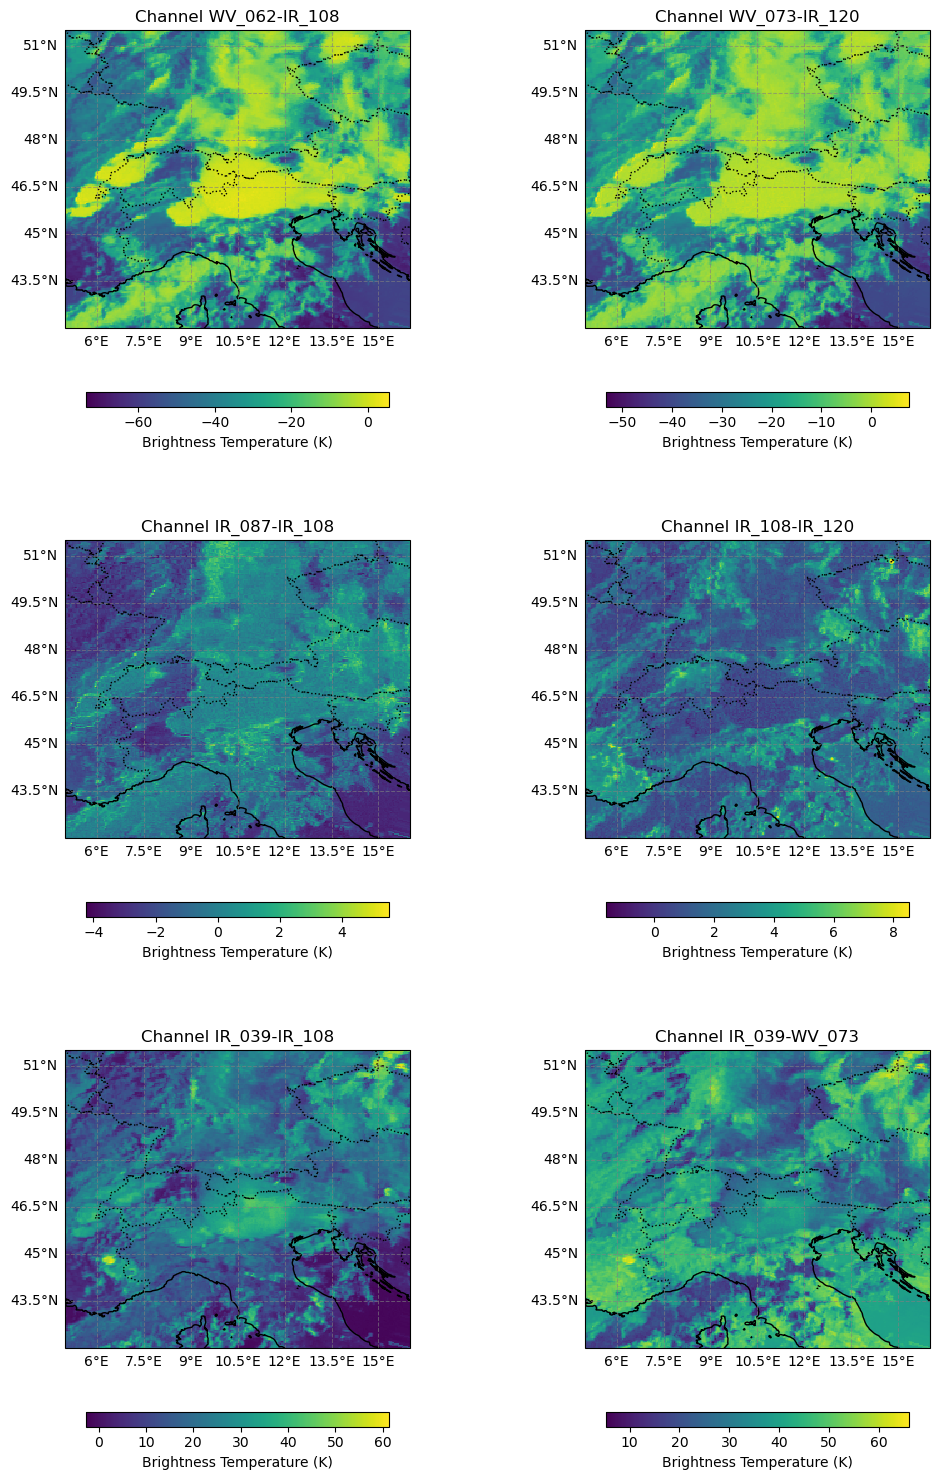

In [6]:
# Create a new dataset for combinations, copying coordinates from the dataset we are using
combinations_ds = xr.Dataset(coords=ds.coords)
#print(combinations_ds)

# Calculate combinations and add them to the new dataset
combinations_ds['WV_062-IR_108'] = ds['WV_062'] - ds['IR_108']
combinations_ds['IR_087-IR_108'] = ds['IR_087'] - ds['IR_108']
combinations_ds['IR_108-IR_120'] = ds['IR_108'] - ds['IR_120']
combinations_ds['IR_039-IR_108'] = ds['IR_039'] - ds['IR_108']
combinations_ds['IR_039-WV_073'] = ds['IR_039'] - ds['WV_073']
combinations_ds['WV_073-IR_120'] = ds['WV_073'] - ds['IR_120']

print(combinations_ds)

#plot each combination
channels = ['WV_062-IR_108','WV_073-IR_120','IR_087-IR_108', 'IR_108-IR_120', 'IR_039-IR_108' , 'IR_039-WV_073' ]
extent = lon_min, lon_max, lat_min, lat_max = 5., 16., 42., 51.5

# Select a timestamp
data_ss = combinations_ds.isel(time=50)

# Define a Figure
num_rows = 3
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# Plot each channel
for i, channel in enumerate(channels):
    plot_single_map(data_ss, extent, channel,axs[i],'Brightness Temperature (K)','viridis')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Show plot
plt.show()


Questions:

1 6.2-10.8 µm and 7.3-12 µm 

1.1 (1 point) Using the BTD maps derived from the 6.2-10.8 µm and 7.3-12 µm channel differences, can you identify regions indicative of convective cloud activity? Describe the BTD signatures that help distinguish these cloud types 

1.2 (2 points) Both BTD maps from the 6.2-10.8 µm and 7.3-12 µm channel differences appear similar at first glance. What subtle differences can be observed between the two, and how might differences in their respective weighting functions explain these variations? 

1.3 (2 points) Under what circumstances might the BTD exhibit slightly positive values? 


2 8.7 - 10.8 µm 

2.1 (2 points) Explain how the difference between the 8.7 µm and 10.8 µm channels helps differentiate between ice clouds and water clouds. What does a positive/negative BTD typically signify about the cloud's composition?

2.2(1 point) For the channel difference of 8.7-10.8 µm, which areas of the map indicate the presence of ice clouds versus water clouds? Compare this to the CTH (6.2-10.8 µm and 7.3-12 µm), what can you say?

3 10.8 - 12 µm

3.1 (2 points) How can the difference between the 10.8 µm and 12 µm channels be used to distinguish between optically thick and thin clouds?

3.2 (1 points) In the map, where are locatedthe optically thicker clouds. What implications does optical thickness have for weather phenomena like precipitation?

4 3.9 - 10.8 µm and 3.9 - 7.3 µm 

4.1 (1 point) Based on the BTD observed in 3.9 - 7.3 µm channel difference, can you identify areas of the map showing high CWP? What characteristics would you infer about these clouds?

4.2 (2 points)  Which is the main difference between BTD 3.9-10.8 and 3.9-7.3 ? 

Answers:

1.1 The deep convective area are indicated by the less negative area or really close to zero (e.g the yellow patches). Infact the teermal emission of the amotspheric windows (10.8 or 12) would have a similar BT that the upper/middle level water vapor emission (6.2 or 7.3 µm).  

1.2 The value of the 7.3-12 µm maps are just slightly shifted toworads more positive values. This is due to the weighting fuctions. In fact, the 7.3 µm is more sensitive to water vapor layer that are lower in altitude (so higher BT) with respect to the 6.2 µm. 

1.3 Positive diﬀerences may occur when water vapour is present in the stratosphere which has higher BT with respect to the cloud top, which is a still a sign of convective cloud tops.

2.1 The difference between the 8.7 µm and 10.8 µm channels helps differentiate between ice clouds and water clouds because of the distinct absorption properties of ice and water at these wavelengths. A positive BTD typically indicates ice clouds, as ice has higher absorption at 8.7 µm compared to water, resulting in colder BT at 8.7 µm and hence a positive difference when subtracted from the 10.8 µm BT.

2.2 The presence of the ice corresponds to the clouds with higher CTH.

3.1 Optically thick clouds tend to absorb and re-emit infrared radiation more effectively, resulting in a smaller temperature difference (BTD), whereas optically thin clouds show larger BTD due to less absorption and more ground radiation passing through. 

3.2 Again, the cloud patch in the middle of the doamin, that shows the convective clouds. This property is crucial for predicting precipitation, as optically thick clouds are more likely to produce significant rainfall.

4.1 Large particles together with a high optical thickness (high CWP) result in medium values of BTD. So the area with medium-high BTD likely correspond to the precipitating clouds.

4.2 higher ΔT3.9-7.3 values compared to ΔT3.9-10.8. This is due to the diminishing effect of the water vapour absorption and emission in mid- to low tropospheric levels on the BT in the 7.3 µm channel. SO the high CWP doesn't strictly correspond to the medium range of BTD.


## Resources

MSG Data can be freely downloaded from EUMETSAT: 

https://www.eumetsat.int/

For handling satellite using Python, Satpy package is highly recommended: 

https://satpy.readthedocs.io/en/stable/

Community about satllite remote sensing, Pytroll: 

https://pytroll.github.io/

More general Python tutorial

https://comptools.climatematch.io/tutorials/intro.html

https://unidata.github.io/python-training/python/intro-to-python/

https://projectpythia.org/

## References

Some papers about satellite remote sensing for precipitation

Inoue, T. (1987). A cloud type classification with NOAA 7 split‐window measurements. Journal of Geophysical Research: Atmospheres, 92(D4), 3991-4000.

Lazri, M., Ameur, S., Brucker, J.M. et al. Identification of raining clouds using a method based on optical and microphysical cloud properties from Meteosat second generation daytime and nighttime data. Appl Water Sci 3, 1–11 (2013). https://doi.org/10.1007/s13201-013-0079-0

Lazri, M., Ameur, S., Brucker, J. M., & Ouallouche, F. (2014). Convective rainfall estimation from MSG/SEVIRI data based on different development phase duration of convective systems (growth phase and decay phase). Atmospheric research, 147, 38-50.

Nauss, T., & Kokhanovsky, A. A. (2006). Discriminating raining from non-raining clouds at mid-latitudes using multispectral satellite data. Atmospheric Chemistry and Physics, 6(12), 5031-5036.

Schmetz, J., Tjemkes, S. A., Gube, M., & Van de Berg, L. (1997). Monitoring deep convection and convective overshooting with METEOSAT. Advances in Space Research, 19(3), 433-441.

Strabala, K. I., S. A. Ackerman, and W. P. Menzel, 1994: Cloud Properties inferred from 812-µm Data. J. Appl. Meteor. Climatol., 33, 212–229, https://doi.org/10.1175/1520-0450(1994)033<0212:CPIFD>2.0.CO;2. 

Thies, B., Nauss, T., & Bendix, J. (2008). Delineation of raining from non-raining clouds during nighttime using Meteosat-8 data. Meteorol. Appl, 15, 219-230.

Thies, B., Turek, A., Nauss, T., & Bendix, J. (2010). Weather type dependent quality assessment of a satellite-based rainfall detection scheme for the mid-latitudes. Meteorology and atmospheric physics, 107, 81-89.


